In [1]:
from numpy import *
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.vector_sources_XY import Vector_source_XY
from diffractio.vector_masks_XY import Vector_mask_XY
from diffractio.vector_fields_XY import Vector_field_XY

from scipy.special import j1
from numpy.fft import fft,ifft,fft2,ifft2,fftshift,ifftshift

## lens transform

### low NA 

In [3]:
diameter = 2 * mm
focal = 25 * mm

x0 = np.linspace(-diameter / 2, diameter / 2, 1024)
y0 = np.linspace(-diameter / 2, diameter / 2, 1024)
wavelength = 0.6238 * um

In [10]:
NA = sin(arctan(diameter/(2*focal)))
print("NA = ", NA)

NA =  0.03996803834887158


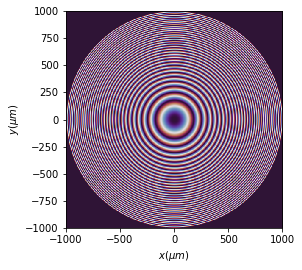

In [5]:
u0 = Scalar_source_XY(x=x0, y=y0, wavelength=wavelength)
u0.plane_wave()

t0 = Scalar_mask_XY(x=x0, y=y0, wavelength=wavelength)
t0.lens(r0=(0 * um, 0 * um),
        radius=(diameter / 2, diameter / 2),
        focal=(focal, focal))

t0.draw('phase')

u1 = u0 * t0

Wall time: 2.44 s


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x211813ec3a0>)

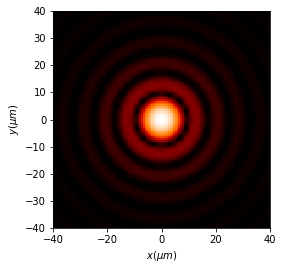

In [6]:
%%time
u2_rs = u1.RS(z=focal)

u2_rs.cut_resample(x_limits=(-40, 40),
                   y_limits=(-40, 40),
                   num_points=(128, 128),
                   new_field=False,
                   interp_kind=(3, 1))

u2_rs.draw(logarithm=1e-2)

Wall time: 328 ms


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x211810606d0>)

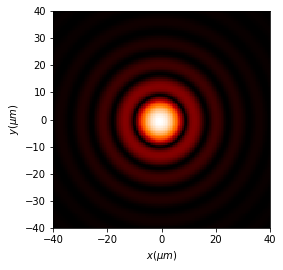

In [7]:
%%time
xout=np.linspace(-40,40,128)
yout=np.linspace(-40,40,128)
u2_czt = u1.CZT(z=focal, xout=xout, yout=yout)

u2_czt.draw(logarithm=1e-2)

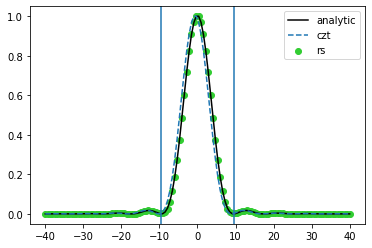

In [13]:
# analytical result
a = diameter/2
k = 2*np.pi/wavelength
f = focal
int_func = lambda x: (j1(a*x*k/f)/x)**2
int_analytic = int_func(xout)
int_analytic /= max(int_analytic)
# czt result
int_czt = abs(u2_czt.u[len(xout)//2])**2
norm = max(int_czt)
int_czt /= norm
int_rs = abs(u2_rs.u[len(xout)//2])**2
norm = max(int_rs)
int_rs /= norm
plt.plot(xout,int_analytic,label='analytic',c='k')
plt.plot(xout,int_czt,'--',label='czt')
plt.scatter(xout,int_rs,label='rs',c='limegreen')
plt.axvline(1.22*wavelength/(2*NA))
plt.axvline(-1.22*wavelength/(2*NA))
plt.legend()

### high NA 
fails to produce diffraction limited spot size for input grid size up to 4096 wide, but both RS, CZT, and ASM remain in agreement

In [90]:
diameter = 1 * mm # lens diameter
f = sqrt(3)*(diameter/2)
# ASM validity condition, if input is zero-padded with N zeros each direction 
lmbda = 0.5 * um
z = f

dx = 0.55*lmbda
N = 2**(int(log2(diameter/dx))+1) # number of points is the nearest power of 2 which gives a wide enough grid
width = N*dx
print(f"N={N}, dx={dx} um, width={width} um")
if dx > lmbda/2:
    print("warning: ASM sampling is valid but diffracted limited features may not be resolved")

assert z < (2*N**2*dx/lmbda)*sqrt(1-(lmbda/(2*dx))**2), "z too short for ASM to be valid"

x0 = linspace(-width / 2, width / 2, N)
y0 = x0
k = 2*pi/lmbda

# for the output resampling
xmin = -10*um
xmax = -xmin
ymin = xmin
ymax = xmax
samples=256

NA = sin(arctan((diameter/(2*f))))
print("NA = ",NA)

N=4096, dx=0.275 um, width=1126.4 um
NA =  0.5


In [98]:
lmbda*f/diameter

0.4330127018922193

In [91]:
u0 = Scalar_source_XY(x=x0, y=y0, wavelength=lmbda)
u0.plane_wave()

t0 = Scalar_mask_XY(x=x0, y=y0, wavelength=lmbda)
t0.lens(r0=(0 * um, 0 * um),
        radius=(diameter / 2, diameter / 2),
        focal=(focal, focal))

# t0.draw()

u1 = u0 * t0

In [92]:
%%time
# ASM

# define k space grid and field
dfx = 1/(width)
fx_list = arange(-N,N,1)*dfx # equivalent to zero-padding
kx_list = 2*pi*fx_list
ky_list = -kx_list
KX, KY = meshgrid(kx_list, ky_list)
KZ_real = real(sqrt(k**2 - KX**2 - KY**2 + 0j))
KZ_imag = imag(sqrt(k**2 - KX**2 - KY**2 + 0j))
KZ = KZ_real + 1j*abs(KZ_imag)
u1_kspace = fftshift(fft2(pad(u1.u, N//2))) # k space from zero-padded array

# propagate
phase = f*KZ_real % 2*pi
u2_kspace = u1_kspace*exp(1j*z*KZ)

# transform back to real space
u2 = ifft2(u2_kspace)
# u2 = u2[N//2-1:N//2-1+N,N//2-1:N//2-1+N] # get rid of the zero padding

Wall time: 1min 20s


In [100]:
1/(2*pi*dfx*N), 1/lmbda

(0.04376760935027122, 2.0)

In [70]:
# u2 = u2[N//2-1:N//2-1+N,N//2-1:N//2-1+N]
int_asm = real(conjugate(u2)*u2)
int_asm /= amax(int_asm)

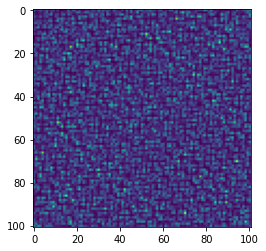

In [97]:
plt.imshow(int_asm[N//2-1 - 100:N//2-1+N - 100,N//2-1 -100:N//2-1+N -100])

In [80]:
u2.shape

(4096, 4096)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x1cd95f53490>)

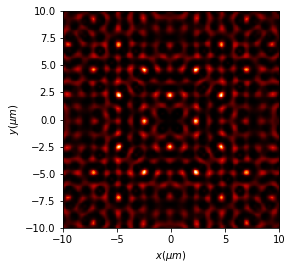

In [93]:
u2_asm = Scalar_source_XY(x=arange(-width,width,dx), y=arange(-width,width,dx), wavelength=lmbda)
u2_asm.u = u2
u2_asm.cut_resample(x_limits=(xmin, xmax),
                   y_limits=(ymin, ymax),
                   num_points=(samples,samples),
                   new_field=False,
                   interp_kind=(3, 1))
u2_asm.draw(logarithm=False)

Wall time: 5min 51s 2.86


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x2474f9f9a00>)

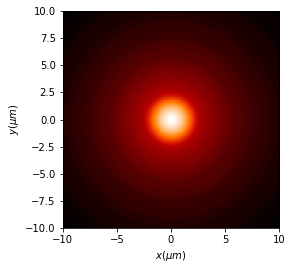

In [7]:
%%time

# RS
u2_rs = u1.RS(z=focal, verbose=True)

u2_rs.cut_resample(x_limits=(xmin, xmax),
                   y_limits=(ymin, ymax),
                   num_points=(samples,samples),
                   new_field=False,
                   interp_kind=(3, 1))
u2_rs.draw(logarithm=False)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x24751296e50>)

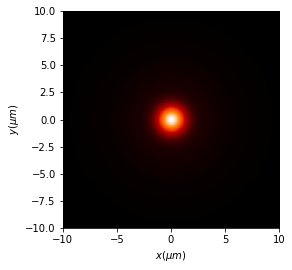

In [29]:
u2_rs.draw(logarithm=False)

num x, num y, num z = 512, 512, 1
Wall time: 424 ms


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x21181c3ea90>)

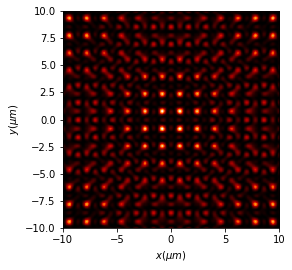

In [22]:
%%time
xout=np.linspace(xmin,xmax,samples)
yout=np.linspace(ymin,ymax,samples)
u2_czt = u1.CZT(z=focal, xout=xout, yout=yout,
               verbose=True)

u2_czt.draw(logarithm=False) #logarithm=1e-2)

num x, num y, num z = 512, 512, 1
Wall time: 17.7 s


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x2474ff99e20>)

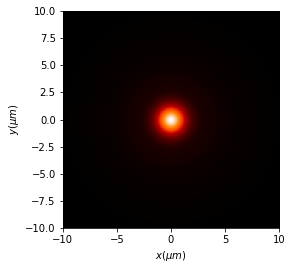

In [12]:
%%time
xout=np.linspace(xmin,xmax,samples)
yout=np.linspace(ymin,ymax,samples)
u2_czt = u1.CZT(z=focal, xout=xout, yout=yout,
               verbose=True)

u2_czt.draw(logarithm=False) #logarithm=1e-2)

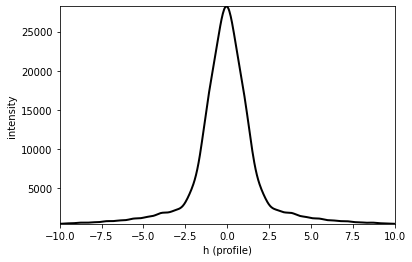

In [189]:
u2_czt.draw_profile(point1=(xmin,0),point2=(xmax,0))
plt.show()

NameError: name 'u2_asm' is not defined

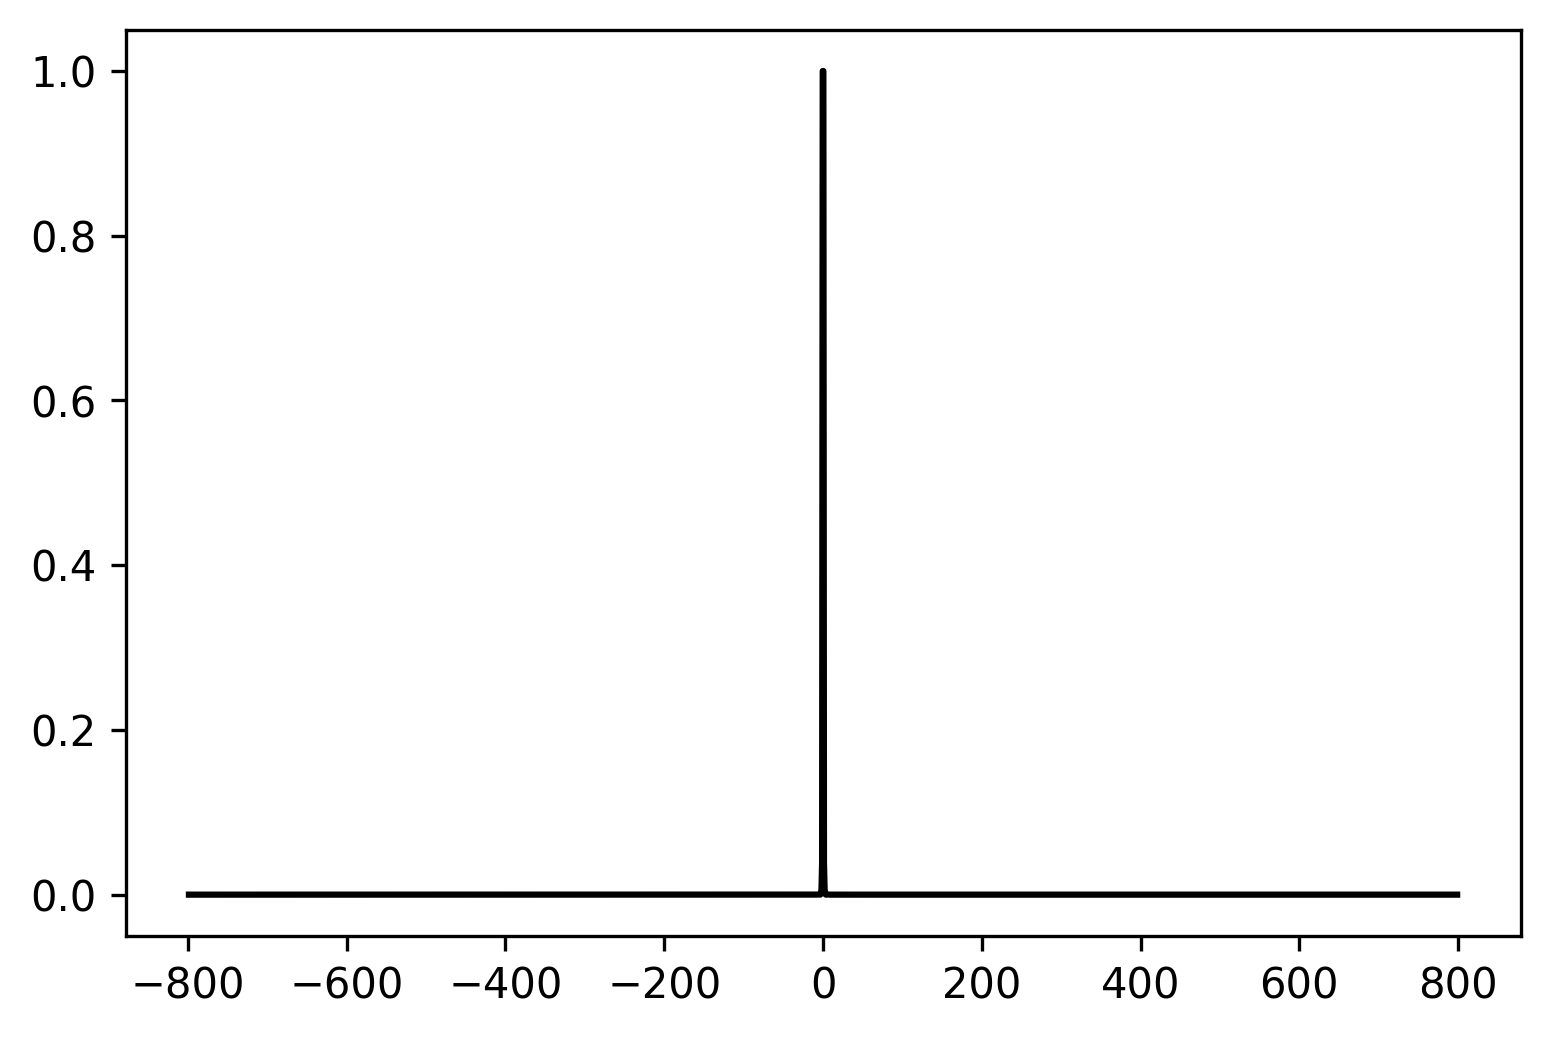

In [50]:
include = ['asm'] #'rs','czt','asm'] # remove ones you don't want

xout = x0

# analytical result
a = diameter/2
k = 2*np.pi/lmbda
f = focal
int_func = lambda x: (j1(a*x*k/f)/x)**2
int_analytic = int_func(xout)
int_analytic /= max(int_analytic)

fig,ax = plt.subplots(dpi=300)
ax.plot(xout,int_analytic,label='analytic',c='k')

if 'czt' in include:
    int_czt = abs(u2_czt.u[len(xout)//2])**2
    norm = max(int_czt)
    int_czt /= norm
    ax.plot(xout,int_czt,'--',label='CZT',c='orange')
    
if 'asm' in include:
    int_asm = abs(u2_asm.u[len(xout)//2])**2
    norm = max(int_asm)
    int_asm /= norm
    ax.scatter(xout,int_asm,label='ASM',c='purple',s=4,marker="P")

if 'rs' in include:
    int_rs = abs(u2_rs.u[len(xout)//2])**2
    norm = max(int_rs)
    int_rs /= norm
    ax.scatter(xout,int_rs,label='RS',c='limegreen',s=2)

ax.set_xlim((-0.1*width/2,0.1*width/2))
# these diverge from the 1st Airy minima at high NA because the NA is outside the paraxial approximation
plt.axvline(-1.22*lmbda/(2*NA),label='Airy 1st minima')
plt.axvline(1.22*lmbda/(2*NA)) 
plt.legend()

In [110]:
1.22*0.78*um/0.6

1.586

In [127]:
dz_list

array([0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985, 0.99 ,
       0.995, 1.   ])

In [141]:
%%time
profiles = []
xout=np.linspace(xmin,xmax,samples)
yout=np.linspace(ymin,ymax,samples)
dz_list = linspace(0.97,0.99,11) # units focal length
for dz_frac in dz_list:
    u2_czt = u1.CZT(z=dz_frac*focal, xout=xout, yout=yout,
                   verbose=True)
    print(dz_frac*focal/mm)
    profiles.append(u2_czt.u[len(xout)//2])
    
#     u2_czt.draw_profile(point1=(xmin,0),point2=(xmax,0))
#     plt.show()

num x, num y, num z = 512, 512, 1
1.6800892833418108
num x, num y, num z = 512, 512, 1
1.6835533849569486
num x, num y, num z = 512, 512, 1
1.6870174865720864
num x, num y, num z = 512, 512, 1
1.6904815881872242
num x, num y, num z = 512, 512, 1
1.6939456898023617
num x, num y, num z = 512, 512, 1
1.6974097914174997
num x, num y, num z = 512, 512, 1
1.7008738930326375
num x, num y, num z = 512, 512, 1
1.704337994647775
num x, num y, num z = 512, 512, 1
1.707802096262913
num x, num y, num z = 512, 512, 1
1.7112661978780506
num x, num y, num z = 512, 512, 1
1.7147302994931883
Wall time: 4min 10s


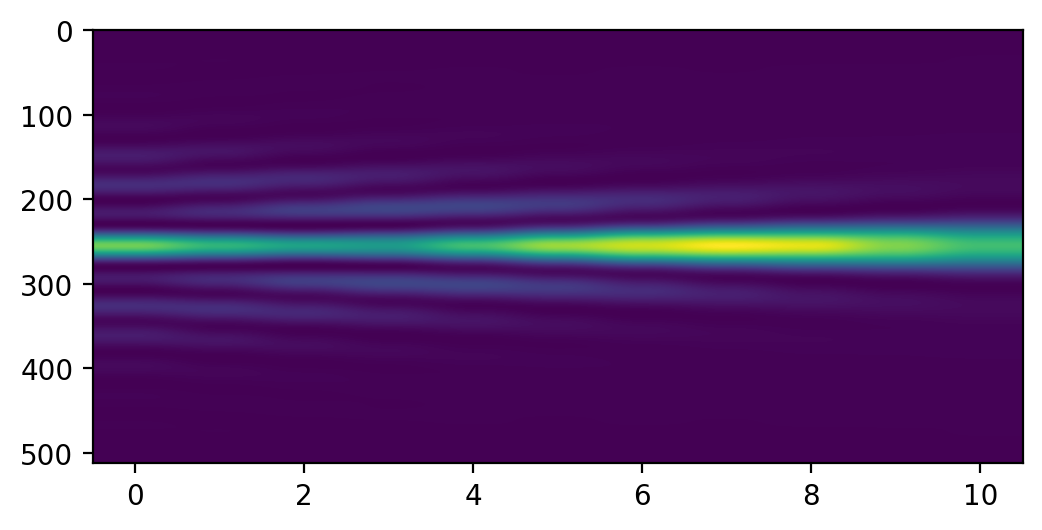

In [142]:
fig,ax = plt.subplots(dpi=200)
int_xz_czt=abs(np.array(profiles,dtype=complex).transpose())**2
ax.imshow(int_xz_czt)
ax.set_aspect(0.01)

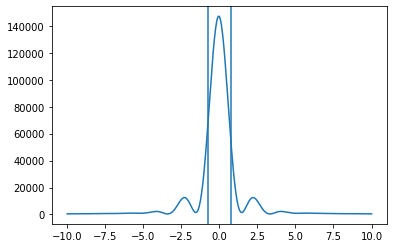

In [143]:
I0max = 0
imax = 0
int_max = zeros(len(xout))
for i,x in enumerate(profiles):
    intensity = abs(np.array(x,complex))**2
    _max = max(intensity)
    if _max > I0max:
        I0max = _max 
        imax = i
        int_max = intensity
plt.plot(xout,int_max)
plt.axvline(-1.22*wavelength/(2*NA))
plt.axvline(1.22*wavelength/(2*NA))

In [145]:
# there is evidently a focal shift from the expectation
dz_list[imax]*focal, focal, dz_list[imax]

(1704.337994647775, 1732.0508075688772, 0.984)

In [118]:
# depth of field for a given NA
(wavelength/(NA)**2)/um

2.4952

In [109]:
len(profiles[0])

512

In [110]:
len(xout)

512

### high NA - comparison with vector diffraction

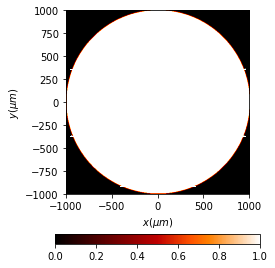

In [161]:
# u0 and t0 defined in the previous section
EM0 = Vector_source_XY(x=x0, y=y0, wavelength=wavelength)
EM0.constant_polarization(u0, v=(1, 0))

M1 = Vector_mask_XY(x0, y0, wavelength)
M1.polarizer_linear(azimuth=0 * degrees)
M1.apply_scalar_mask(t0)

# todo: multiply the field by the Fresnel
# equations for transmission. see 
# Leutenegger et. al.,"Fast focus field calculations"

EM1 = EM0 * M1
EM1.draw('ellipses', num_ellipses=(11,11))

In [171]:
plt.close?

Object `fig.close` not found.


In [184]:
EM2 = EM1.CZT(focal, xout, yout)

KeyboardInterrupt: 

In [185]:
EM2defocus = EM1.CZT(0.98*focal, xout, yout)

In [180]:
EM2z = EM1.CZT(linspace(0.95,1.05,11)*focal, 0, 0)

(<AxesSubplot:xlabel='z ($\\mu$m)', ylabel='$I_x$'>,
 <AxesSubplot:xlabel='z ($\\mu$m)', ylabel='$I_y$'>)

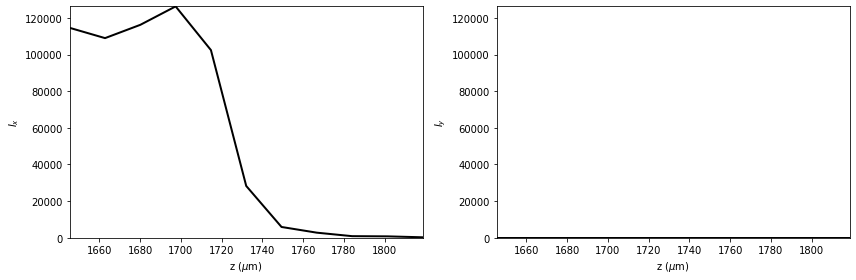

In [181]:
EM2z.draw('intensities')

In [182]:
1700/focal

0.9814954576223639

In [183]:
linspace(0.95,1.05,11)

array([0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05])

(<AxesSubplot:title={'center':'$I_x$'}, xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <AxesSubplot:title={'center':'$I_y$'}, xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>)

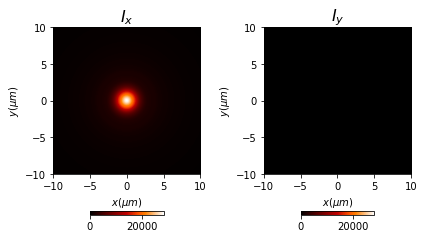

In [164]:
EM2.draw('intensities')

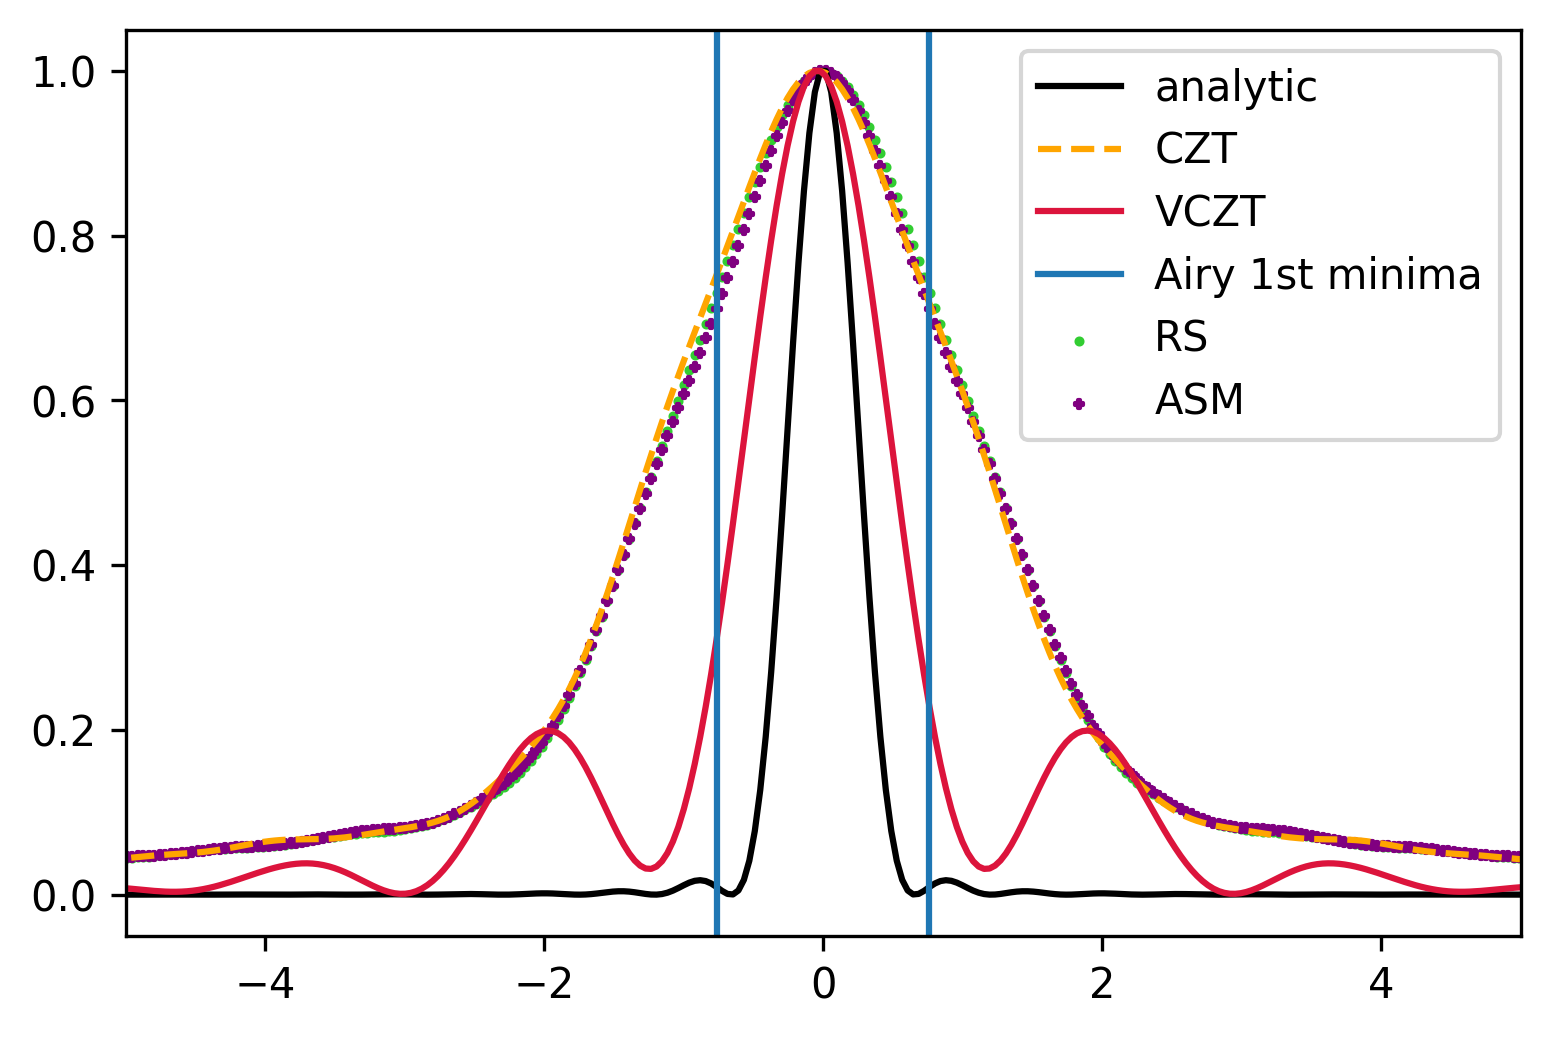

In [192]:
# analytical result
a = diameter/2
k = 2*np.pi/wavelength
f = focal
int_func = lambda x: (j1(a*x*k/f)/x)**2
int_analytic = int_func(xout)
int_analytic /= max(int_analytic)

int_czt = abs(u2_czt.u[len(xout)//2])**2
norm = max(int_czt)
int_czt /= norm

int_asm = abs(u2_asm.u[len(xout)//2])**2
norm = max(int_asm)
int_asm /= norm

int_rs = abs(u2_rs.u[len(xout)//2])**2
norm = max(int_rs)
int_rs /= norm

int_vczt = abs(EM2defocus.Ex[len(xout)//2])**2
norm = max(int_vczt)
int_vczt /= norm

fig,ax = plt.subplots(dpi=300)
ax.plot(xout,int_analytic,label='analytic',c='k')
ax.plot(xout,int_czt,'--',label='CZT',c='orange')
ax.scatter(xout,int_rs,label='RS',c='limegreen',s=2)
ax.scatter(xout,int_asm,label='ASM',c='purple',s=4,marker="P")
ax.plot(xout,int_vczt,label='VCZT',c='crimson')
ax.set_xlim((-5,5))
plt.axvline(-1.22*wavelength/(2*NA),label='Airy 1st minima')
plt.axvline(1.22*wavelength/(2*NA))
plt.legend()

In [176]:
del profiles

In [177]:
del EM0

In [178]:
del u0, t0

In [179]:
import gc
gc.collect()

31651